In [139]:
import pandas as pd
import numpy as np
import random
import string
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns

In [122]:
# Diccionarios de configuración
d1 = {
    "ds": "dataset1",
    "columns": [
        {
            "name": "area",
            "type": "category",
            "values": ["TI", "FIN", "HR"]
        },
        {
            "name": "id",
            "type": "unique"
        }
    ],
    "random": False
}

d2 = {
    "ds": "dataset2",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "area",
            "type": "foreign",
            "values": "dataset1.area"
        },
        {
            "name": "subarea",
            "type": "category",
            "values": ["SA1", "SA2", "SA3", "SA4"]
        }
    ],
    "random": False
}

d3 = {
    "ds": "dataset3",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset2.id"
        },
        {
            "name": "income",
            "type": "numeric",
            "values": {"min": 20000, "max": 50000}
        },
        {
            "name": "goal",
            "type": "numeric",
            "values": {"min": 10000, "max": 30000, "std": 5000, "mean": 20000}
        }
    ],
    "random": True,
    "random_rows": 1000
}

d4 = {
    "ds": "dataset4",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset3.subarea"
        },
        {
            "name": "budget",
            "type": "numeric",
            "values": {"min": 5000, "max": 20000}
        }
    ],
    "random": True,
    "random_rows": 500
}

d5 = {
    "ds": "dataset5",
    "columns": [
        {
            "name": "id",
            "type": "unique"
        },
        {
            "name": "subarea",
            "type": "foreign",
            "values": "dataset4.subarea"
        },
        {
            "name": "expense",
            "type": "numeric",
            "values": {"min": 1000, "max": 15000}
        }
    ],
    "random": True,
    "random_rows": 700
}


In [124]:
# Función para generar un ID único de 16 caracteres
def generate_unique_id(length=16):
    return ''.join(random.choices(string.ascii_letters + string.digits, k=length))

# Función para crear un DataFrame basado en un diccionario de configuración
def create_dataframe_from_dict(config_dict, reference_datasets=None):
    columns = config_dict["columns"]
    if config_dict["random"]:
        max_length = config_dict["random_rows"]
    else:
        max_length = max(len(col["values"]) for col in columns if col["type"] == "category")

    data = {}
    for col in columns:
        if col["type"] == "category":
            if isinstance(col["values"], list):
                data[col["name"]] = np.random.choice(col["values"], max_length)
            else:
                ref_ds, ref_col = col["values"].split('.')
                if reference_datasets is None or ref_ds not in reference_datasets:
                    raise ValueError(f"Reference dataset {ref_ds} not found.")
                if ref_col not in reference_datasets[ref_ds].columns:
                    valid_columns = ', '.join(reference_datasets[ref_ds].columns)
                    raise ValueError(f"Column {ref_col} not found in {ref_ds}. Valid columns are: {valid_columns}")
                data[col["name"]] = np.random.choice(reference_datasets[ref_ds][ref_col], max_length)
        elif col["type"] == "unique":
            data[col["name"]] = [generate_unique_id() for _ in range(max_length)]
        elif col["type"] == "numeric":
            min_val = col["values"]["min"]
            max_val = col["values"]["max"]
            if "std" in col["values"] and "mean" in col["values"]:
                std = col["values"]["std"]
                mean = col["values"]["mean"]
                lower, upper = (min_val - mean) / std, (max_val - mean) / std
                data[col["name"]] = truncnorm.rvs(lower, upper, loc=mean, scale=std, size=max_length)
            else:
                data[col["name"]] = np.random.uniform(min_val, max_val, max_length)
    
    return pd.DataFrame(data)


In [126]:
# Función para construir dataframes desde una lista de configuraciones
def build_dataframes(conf_list):
    reference_datasets = {}
    dataframe_list = []

    for conf in conf_list:
        df = create_dataframe_from_dict(conf, reference_datasets)
        dataframe_list.append(df)
        reference_datasets[conf["ds"]] = df
    
    return dataframe_list

# Implementar la lógica para generar datos truncados
def generate_truncated_normal_data(mean, std, min_val, max_val, size):
    a, b = (min_val - mean) / std, (max_val - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std, size=size)



In [128]:
# Lista de configuraciones
conf_list = [d5, d2, d4, d1, d3]

# Construir los dataframes
dataframe_list = build_dataframes(conf_list)

In [155]:
dataframe_list[4]

,id,income,goal
0,Nlv9XIEHaRzhOHMC,36559.849792,14730.840831
1,X7UENJNQnoaPpf2z,38476.744192,26834.053597
2,4bKckQhWQRP0FgOc,46726.423427,28738.670961
3,ZqCeEbqONXCH9qm0,25811.188386,19942.875717
4,lFEpmRbHFddwLa3u,21987.525661,22012.949839
...,...,...,...
995,PPdogFpPUTfmFWWt,25384.536532,22506.966134
996,IAT9qgMXzsCGB41g,47249.236317,13240.040545
997,sDJflxfI3h2VIeUK,34232.426459,23228.110991
998,9X366W49CtRHSGbf,36303.046481,19716.955484


In [132]:
# Requisito 5: Analizar combinaciones categóricas y extender el dataset
# Suponemos que dataframe_list[2] es el DataFrame generado con random: true
simulation_extended = dataframe_list[2]

# Verificar columnas y tipos de datos
print("Columnas y tipos de datos en simulation_extended:")
print(simulation_extended.dtypes)

# Convertir las columnas categóricas al tipo 'category'
for col in simulation_extended.columns:
    if simulation_extended[col].dtype == 'object':
        simulation_extended[col] = simulation_extended[col].astype('category')

# Verificar y seleccionar solo columnas categóricas
category_cols = simulation_extended.select_dtypes(include=['category']).columns.tolist()
numeric_cols = simulation_extended.select_dtypes(include=['float64', 'int64']).columns.tolist()

print("Columnas categóricas:", category_cols)
print("Columnas numéricas:", numeric_cols)

# Verificar si hay columnas categóricas disponibles
if not category_cols:
    raise ValueError("No categorical columns found in simulation_extended")

# Paso 1: Analizar combinaciones de variables categóricas y calcular probabilidades
category_combinations = simulation_extended.groupby(category_cols, observed=True).size().reset_index(name='counts')
category_combinations['prob'] = category_combinations['counts'] / category_combinations['counts'].sum()

# Paso 2: Generar el nuevo DataFrame basado en combinaciones categóricas
def get_categorical_dataset_simulated(simulation_extended, category_cols, num_records):
    category_combinations['num_samples'] = (category_combinations['prob'] * num_records).round().astype(int)
    simulated = pd.DataFrame()
    
    for _, row in category_combinations.iterrows():
        sample = pd.DataFrame([row[category_cols]] * row['num_samples'], columns=category_cols)
        simulated = pd.concat([simulated, sample], ignore_index=True)
        
    return simulated

# Generar el dataset aleatorio con 100,000 registros basado en combinaciones categóricas
num_records = 100000
final_simulation = get_categorical_dataset_simulated(simulation_extended, category_cols, num_records)

# Paso 3: Extender el DataFrame con las columnas numéricas
def get_numeric_column_simulated(simulated, df_origin, categories, column_name):
    a1 = df_origin.groupby(categories, observed=True, as_index=False).agg({
        column_name: ["min", "max", "mean", "std"]
    })
    
    nc = categories + ["Min", "Max", "Mean", "Std"]
    a1.columns = nc

    column_simulated = pd.DataFrame()
    
    for i in a1.index:
        rs = a1.loc[i]
        segment = simulated[(simulated[categories] == rs[categories].values).all(axis=1)].copy()
        # Validar parámetros de truncnorm
        mean, std, min_val, max_val = rs["Mean"], rs["Std"], rs["Min"], rs["Max"]
        if std > 0 and min_val < max_val:
            data = generate_truncated_normal_data(mean, std, min_val, max_val, segment.shape[0])
        else:
            data = np.full(segment.shape[0], mean)  # Rellenar con el valor medio si std no es válido
        segment[column_name] = data
        column_simulated = pd.concat([column_simulated, segment])

    return column_simulated.reset_index(drop=True)

# Extender el DataFrame con las columnas numéricas
for nc in numeric_cols:
    df_numeric = get_numeric_column_simulated(final_simulation, simulation_extended, category_cols, nc)
    final_simulation[nc] = df_numeric[nc]

print(final_simulation)


Columnas y tipos de datos en simulation_extended:
id         object
budget    float64
dtype: object
Columnas categóricas: ['id']
Columnas numéricas: ['budget']
                     id       budget
0      0SdRUVLVfhjIjAfg  8991.524735
1      0SdRUVLVfhjIjAfg  8991.524735
2      0SdRUVLVfhjIjAfg  8991.524735
3      0SdRUVLVfhjIjAfg  8991.524735
4      0SdRUVLVfhjIjAfg  8991.524735
...                 ...          ...
99995  zoHiDy8enGxGeGz8  8738.239417
99996  zoHiDy8enGxGeGz8  8738.239417
99997  zoHiDy8enGxGeGz8  8738.239417
99998  zoHiDy8enGxGeGz8  8738.239417
99999  zoHiDy8enGxGeGz8  8738.239417

[100000 rows x 2 columns]


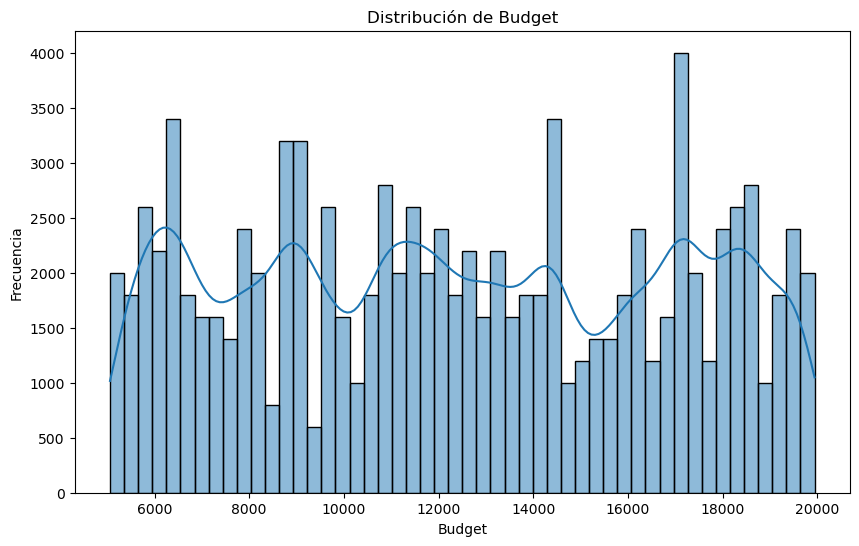

In [141]:
# los gráficos se muestren dentro del cuaderno
%matplotlib inline

# Histograma de la columna 'budget'
plt.figure(figsize=(10, 6))
sns.histplot(final_simulation['budget'], bins=50, kde=True)
plt.title('Distribución de Budget')
plt.xlabel('Budget')
plt.ylabel('Frecuencia')
plt.show()


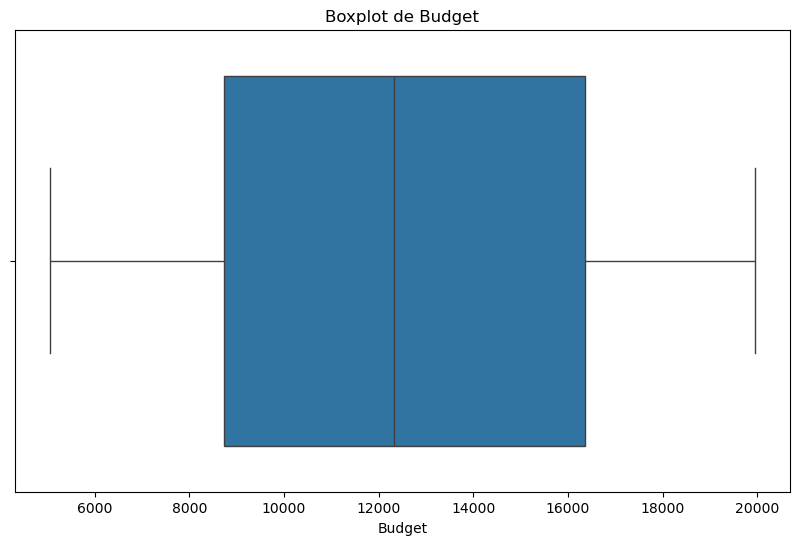

In [143]:
# Gráfico de caja para la columna 'budget'
plt.figure(figsize=(10, 6))
sns.boxplot(x='budget', data=final_simulation)
plt.title('Boxplot de Budget')
plt.xlabel('Budget')
plt.show()


In [157]:
# Definición de nuevas configuraciones de ejemplo
d6 = {
    "ds": "dataset6",
    "columns": [
        {
            "name": "region",
            "type": "category",
            "values": ["North", "South", "East", "West"]
        },
        {
            "name": "employee_id",
            "type": "unique"
        },
        {
            "name": "salary",
            "type": "numeric",
            "values": {"min": 30000, "max": 70000}
        },
        {
            "name": "bonus",
            "type": "numeric",
            "values": {"min": 2000, "max": 10000, "std": 1500, "mean": 5000}
        }
    ],
    "random": True,
    "random_rows": 1500
}

d7 = {
    "ds": "dataset7",
    "columns": [
        {
            "name": "employee_id",
            "type": "unique"
        },
        {
            "name": "region",
            "type": "foreign",
            "values": "dataset6.region"
        },
        {
            "name": "department",
            "type": "category",
            "values": ["HR", "Finance", "IT", "Sales"]
        },
        {
            "name": "performance_score",
            "type": "numeric",
            "values": {"min": 0, "max": 100}
        }
    ],
    "random": True,
    "random_rows": 1000
}

d8 = {
    "ds": "dataset8",
    "columns": [
        {
            "name": "employee_id",
            "type": "unique"
        },
        {
            "name": "department",
            "type": "foreign",
            "values": "dataset7.department"
        },
        {
            "name": "project_count",
            "type": "numeric",
            "values": {"min": 1, "max": 20}
        }
    ],
    "random": True,
    "random_rows": 800
}

# Lista de configuraciones para el segundo ejemplo
conf_list_example_2 = [d8, d7, d6]

# Construir los dataframes para el segundo ejemplo
dataframe_list_example_2 = build_dataframes(conf_list_example_2)

# Imprimir los dataframes generados
for df in dataframe_list_example_2:
    print(df.head(), "\n")


        employee_id  project_count
0  foett6eDW4Wmq5Nq      15.377377
1  RtWqDO3nOFthfxLs      14.953985
2  oXWJkQLqT2zUYMvx       5.849035
3  EEjRxLb9tCTDs8wR      17.624539
4  qxC12Ob7mvx9TDkQ      19.634855 

        employee_id department  performance_score
0  nHNbjhLg7D9Nth0Z    Finance          31.668294
1  ZZ0Dm2ySgxEbuJy3         HR          52.019001
2  r2fiJEKdH8V57rpx         IT           6.336651
3  XGQWSfvehWZdUNYI         HR          66.814200
4  qPhGknt9J77sDjxN         IT          34.584477 

  region       employee_id        salary        bonus
0  South  i6sAwgjzomBZyuXG  51053.392756  6547.240667
1  South  YGM1K8j64zIo0ixI  43366.585568  4182.518953
2  South  qap0MdK2eV3KYWH2  31064.430516  2290.921592
3   East  hbUWIvYRpgMqgCA7  49413.396356  4794.333915
4   West  0L0NYCoYw3IvIRd5  36331.785660  4955.544588 

